In [1]:
technique = 'dyngen'
data_path = f"../data/Dyngen"
root_save_path = f"../saved_results/{technique}"
device = "cuda:0"

In [2]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import torch

import sys
sys.path.append('..')
from src.interface import UnitedNet
from src.configs import *

# Dataset Inspection

In [3]:
with np.load(data_path + '/dyngen_linear_test_cv0_PRmp.npz') as data:
    datakeys = [k for k in data.keys()]
    for k in datakeys:
        print(k, data[k].shape)

labels (100,)
n_views ()
view_0 (100, 100)
view_1 (100, 100)
view_2 (100, 100)
view_3 (100, 100)


In [4]:
with np.load(data_path + '/dyngen_linear_train_cv0_PRmp.npz') as data:
    datakeys = [k for k in data.keys()]
    for k in datakeys:
        print(k, data[k].shape)

labels (400,)
n_views ()
view_0 (400, 100)
view_1 (400, 100)
view_2 (400, 100)
view_3 (400, 100)


# Load Data

In [5]:
trainingfiles = ['dyngen_linear_train_cv0_pPRm.npz',
                 'dyngen_linear_train_cv1_pPRm.npz',
                 'dyngen_linear_train_cv2_pPRm.npz',
                 'dyngen_linear_train_cv3_pPRm.npz',
                 'dyngen_linear_train_cv4_pPRm.npz',
                 ]

testingfiles = ['dyngen_linear_test_cv0_pPRm.npz',
                'dyngen_linear_test_cv1_pPRm.npz',
                'dyngen_linear_test_cv2_pPRm.npz',
                'dyngen_linear_test_cv3_pPRm.npz',
                'dyngen_linear_test_cv4_pPRm.npz',
                ]

cross_validation_fold = 5

def prepare_data(pathname, filename):
    _data = np.load(f"{pathname}/{filename}")
    modalities_num = _data['n_views']
    datalist = []
    for i in range(modalities_num):
        adata = ad.AnnData(_data[f'view_{i}'])
        adata.obs['label'] = _data['labels']
        datalist.append(adata)
    return datalist

# Training

In [6]:
for i in range(cross_validation_fold):
    adatas_train = prepare_data(data_path, trainingfiles[i])
    adatas_test = prepare_data(data_path, testingfiles[i])
    save_path = f"{root_save_path}/cv_{i}"
    model = UnitedNet(save_path, device=device, technique=dyngen_config)
    model.train(adatas_train, verbose=False)

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


training


100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


training


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


training


100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


training


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


training


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


# Evaluation

## ARI

In [7]:
from sklearn.metrics import adjusted_rand_score, roc_auc_score, f1_score
from matplotlib import pyplot as plt
ari_res = []
for i in range(cross_validation_fold):
    ari_epoch_list = []
    adatas_test = prepare_data(data_path, testingfiles[i])
    for epoch in range(1, dyngen_config['train_epochs']):
        testmodel = UnitedNet(root_save_path, device=device, technique=dyngen_config)
        model.load_model(f"{root_save_path}/cv_{i}/train_epoch_{epoch}.pt",device=torch.device(device))
        model.model.device_in_use = device
        predict_label = model.predict_label(adatas_test)
        ari_epoch_list.append(adjusted_rand_score(np.array(adatas_test[0].obs['label']), predict_label))
    ari_res.append(ari_epoch_list)


/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


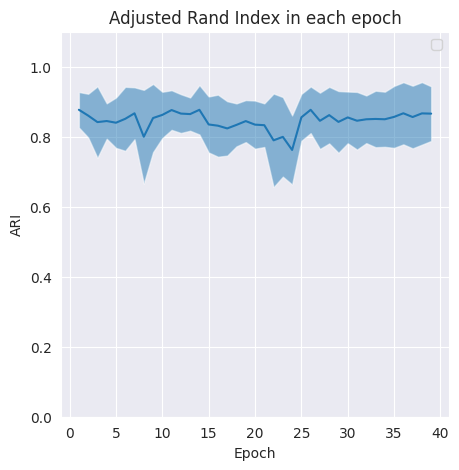

Mean ARI: 0.8465468433602685; Mean STD: 0.07883153938422198


In [44]:
ari_res = np.array(ari_res)
ari_std = np.std(ari_res, axis=0)
ari_mean = np.mean(ari_res, axis=0)
plt.figure(figsize=(5, 5))
# for i in range(len(ari_res)):
#     plt.plot(ari_res[i])
x = [i for i in range(1, len(ari_res[0]) + 1)]
plt.plot(x, ari_mean)
plt.fill_between(x, ari_mean-ari_std, ari_mean+ari_std, alpha=0.5)
plt.ylim(0, 1.1)
plt.xlabel("Epoch")
plt.ylabel("ARI")
plt.title("Adjusted Rand Index in each epoch")
plt.legend()
plt.show()
print(f'Mean ARI: {np.mean(ari_mean)}; Mean STD: {np.mean(ari_std)}')

## ACC

In [38]:
from sklearn.metrics import accuracy_score
acc_res = []
for i in range(cross_validation_fold):
    acc_epoch_list = []
    adatas_test = prepare_data(data_path, testingfiles[i])
    for epoch in range(1, dyngen_config['train_epochs']):
        testmodel = UnitedNet(root_save_path, device=device, technique=dyngen_config)
        testmodel.load_model(f"{root_save_path}/cv_{i}/train_epoch_{epoch}.pt",device=torch.device(device))
        testmodel.model.device_in_use = device
        predict_label = testmodel.predict_label(adatas_test)
        acc_epoch_list.append(accuracy_score(np.array(adatas_test[0].obs['label']),
                                            predict_label,))
    acc_res.append(acc_epoch_list)

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


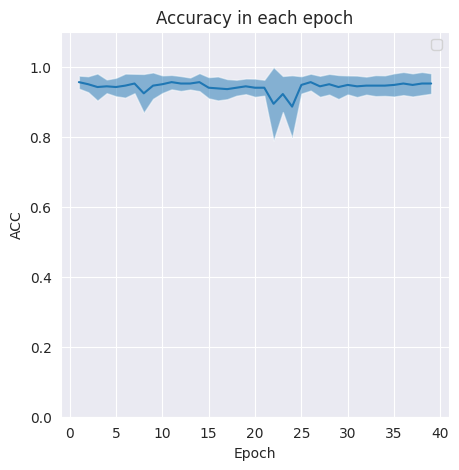

Mean ACC: 0.9428205128205127; Mean STD: 0.0326341823764637


In [43]:
acc_res = np.array(acc_res)
acc_std = np.std(acc_res, axis=0)
acc_mean = np.mean(acc_res, axis=0)
plt.figure(figsize=(5, 5))
# for i in range(len(acc_res)):
#     plt.plot(acc_res[i])
x = [i for i in range(1, len(acc_res[0]) + 1)]
plt.plot(x, acc_mean)
plt.fill_between(x, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5)
plt.ylim(0, 1.1)
plt.xlabel("Epoch")
plt.ylabel("ACC")
plt.title("Accuracy in each epoch")
plt.legend()
plt.show()
print(f'Mean ACC: {np.mean(acc_mean)}; Mean STD: {np.mean(acc_std)}')

## AUC Score

In [33]:
from sklearn.metrics import roc_auc_score

auc_res = []
for i in range(cross_validation_fold):
    auc_epoch_list = []
    adatas_test = prepare_data(data_path, testingfiles[i])
    for epoch in range(1, dyngen_config['train_epochs']):
        testmodel = UnitedNet(root_save_path, device=device, technique=dyngen_config)
        testmodel.load_model(f"{root_save_path}/cv_{i}/train_epoch_{epoch}.pt",device=torch.device(device))
        testmodel.model.device_in_use = device
        predict_proba = testmodel.predict_prob(adatas_test)
        auc_epoch_list.append(roc_auc_score(np.array(adatas_test[0].obs['label']),
                                            predict_proba,
                                            multi_class="ovr",))
    auc_res.append(auc_epoch_list)

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


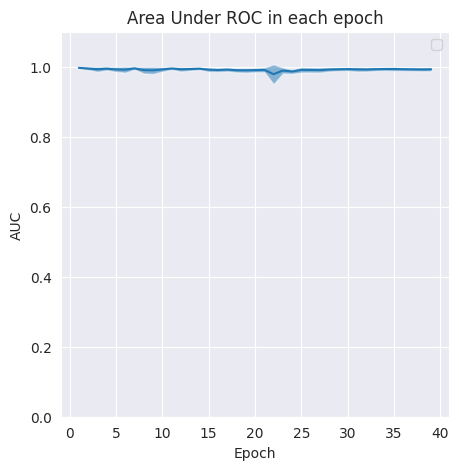

Mean AUC: 0.9918076029645655; Mean STD: 0.006314782752620975


In [41]:
from matplotlib import pyplot as plt
auc_res = np.array(auc_res)
auc_std = np.std(auc_res, axis=0)
auc_mean = np.mean(auc_res, axis=0)
plt.figure(figsize=(5, 5))
# for i in range(len(auc_res)):
#     plt.plot(auc_res[i])
x = [i for i in range(1, len(auc_res[0]) + 1)]
plt.plot(x, auc_mean)
plt.fill_between(x, auc_mean-auc_std, auc_mean+auc_std, alpha=0.5)
plt.ylim(0, 1.1)
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Area Under ROC in each epoch")
plt.legend()
plt.show()
print(f'Mean AUC: {np.mean(auc_mean)}; Mean STD: {np.mean(auc_std)}')

## ROC

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


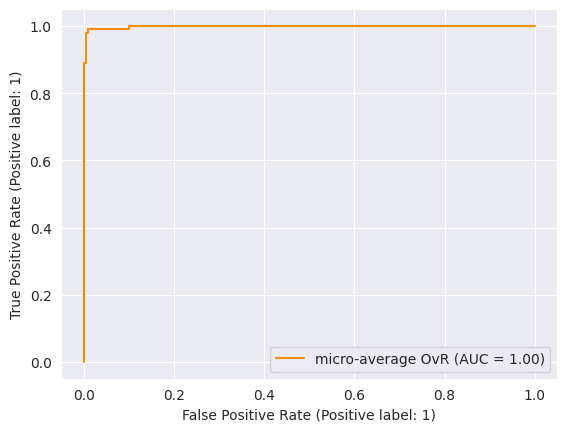

In [13]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

adatas_test = prepare_data(data_path, testingfiles[0])
testmodel = UnitedNet(root_save_path, device=device, technique=dyngen_config)
testmodel.load_model(f"{root_save_path}/cv_0/train_best.pt",device=torch.device(device))
testmodel.model.device_in_use = device
predict_proba = testmodel.predict_prob(adatas_test)
y_real = adatas_test[0].obs['label']
y_bin = label_binarize(y_real, classes=[0, 1, 2])

RocCurveDisplay.from_predictions(
    y_bin.ravel(),
    predict_proba.ravel(),
    name="micro-average OvR",
    color="darkorange",
    # plot_chance_level=True,
)